Deteksi Churn Pelanggan Layanan Berlangganan Menggunakan XGBoost

Notebook ini menyajikan alur lengkap mulai dari EDA hingga interpretasi model menggunakan **XGBoost**, sesuai dengan ketentuan tugas.

 1. Load Data & Exploratory Data Analysis (EDA)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


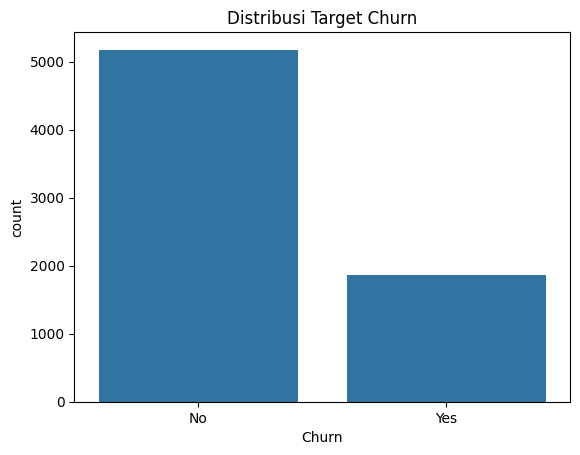

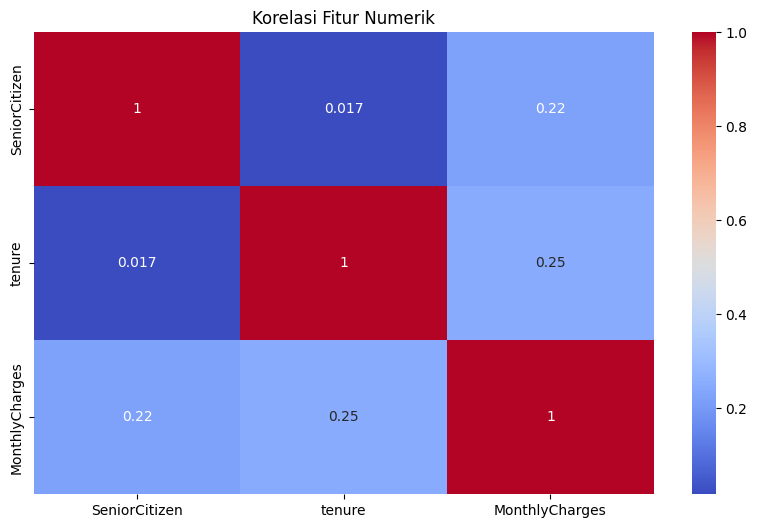

In [42]:

#📌 1. Import Library
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)

from xgboost import XGBClassifier, plot_importance

#📌 2. Load Dataset
df = pd.read_csv("telco_churn.csv")
df.head()

df.info()

#📌 3. Exploratory Data Analysis (EDA)
#3.1 Cek Missing Values
df.isnull().sum()


#3.2 Distribusi Target (Cek Imbalance)
sns.countplot(x="Churn", data=df)
plt.title("Distribusi Target Churn")
plt.show()

df["Churn"].value_counts(normalize=True)


#3.3 Korelasi Fitur Numerik
plt.figure(figsize=(10,6))
sns.heatmap(
    df.select_dtypes(include=np.number).corr(),
    annot=True,
    cmap="coolwarm"
)
plt.title("Korelasi Fitur Numerik")
plt.show()

**Analisis:**

* Target tidak seimbang (sekitar 27% churn, 73% tidak churn)
* Diperlukan penanganan imbalance saat modeling

---

2. Preprocessing Data

In [43]:
# Encoding Target 
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["Churn"] = le.fit_transform(df["Churn"])

df["Churn"].value_counts()


# Drop Kolom ID (Jika Ada)
df = df.drop(columns=["customerID"], errors="ignore")

# Encoding Variabel Kategorikal
df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded.head()


,SeniorCitizen,tenure,MonthlyCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,TotalCharges_995.35,TotalCharges_996.45,TotalCharges_996.85,TotalCharges_996.95,TotalCharges_997.65,TotalCharges_997.75,TotalCharges_998.1,TotalCharges_999.45,TotalCharges_999.8,TotalCharges_999.9
0,0,1,29.85,0,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,0,34,56.95,0,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0,2,53.85,1,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0,45,42.30,0,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,0,2,70.70,1,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [44]:
X = df_encoded.drop(columns="Churn")
y = df_encoded["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

y_train.value_counts()


Churn
0    4139
1    1495
Name: count, dtype: int64

3. Training Model XGBoost

In [45]:
#Handling Imbalanced Data
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
scale_pos_weight




#Training Model XGBoost
xgb_model = XGBClassifier(
    objective="binary:logistic",
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    random_state=42
)

xgb_model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

4. Evaluasi Model

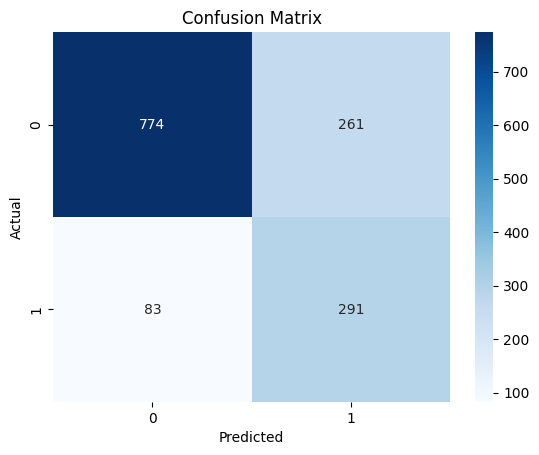

              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1035
           1       0.53      0.78      0.63       374

    accuracy                           0.76      1409
   macro avg       0.72      0.76      0.72      1409
weighted avg       0.80      0.76      0.77      1409



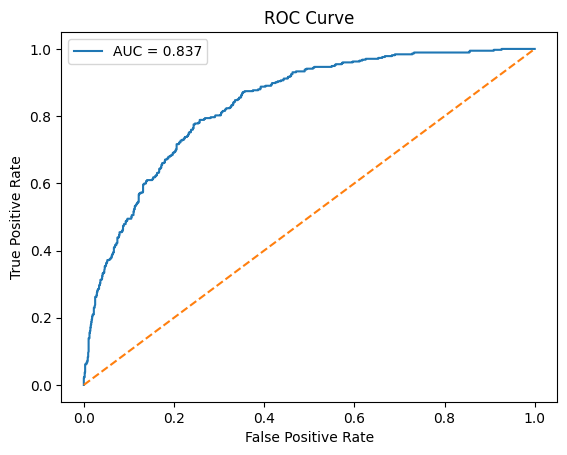

In [46]:
#Confusion Matrix
y_pred = xgb_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))

# ROC – AUC Curve
y_prob = xgb_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)

fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

 5. Feature Importance (Interpretability)

<Figure size 1000x600 with 0 Axes>

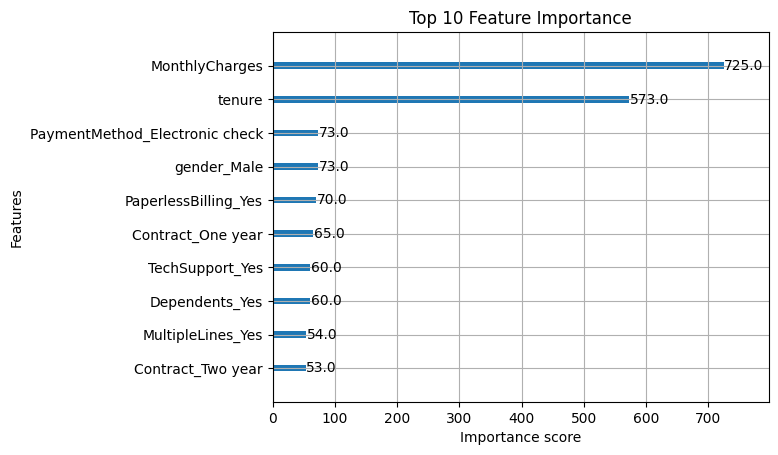

In [47]:
plt.figure(figsize=(10,6))
plot_importance(xgb_model, max_num_features=10)
plt.title("Top 10 Feature Importance")
plt.show()


### Analisis Feature Importance

* **tenure**: pelanggan baru lebih berisiko churn
* **Contract**: kontrak bulanan memiliki churn lebih tinggi
* **MonthlyCharges**: biaya tinggi meningkatkan churn

Fitur-fitur ini **masuk akal secara bisnis**, membuktikan bahwa model XGBoost tidak hanya akurat tetapi juga interpretatif.



## Kesimpulan

* XGBoost efektif mendeteksi churn pelanggan
* Penanganan imbalance meningkatkan kemampuan model mengenali churn
* Feature importance membantu pengambilan keputusan bisnis


In [49]:
import pickle

pickle.dump(xgb_model, open("churn_xgb.pkl", "wb"))
pickle.dump(X.columns.tolist(), open("feature_names.pkl", "wb"))

print("Model & feature names berhasil disimpan")


Model & feature names berhasil disimpan
